<IPython.core.display.Javascript object>


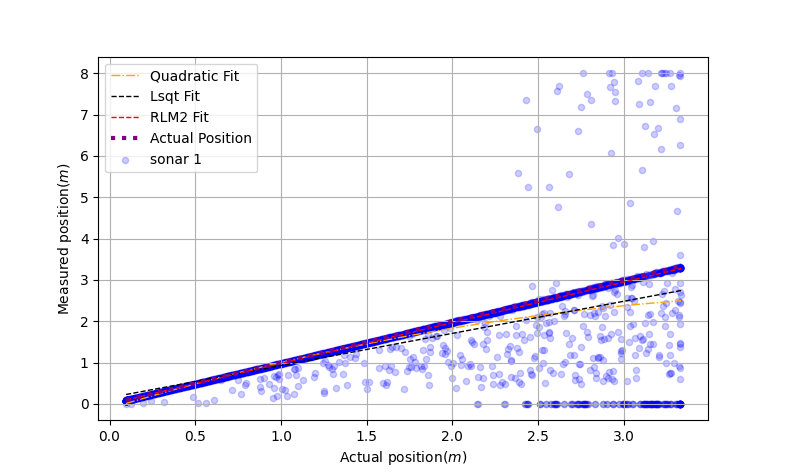

In [8]:
# 482 Assignment 1,  Part 1
# Authors: Martin Cruz & Will Eldridge
'''PART1 : 1.1 Sensor models'''
""" SONAR 1  sensor model """
# Modules needed 
import numpy as np
import time
import array
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import os
import warnings
from numpy import *
from matplotlib.pyplot import subplots, show
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

%matplotlib notebook 
#added so its possible to zoom in image 

# Load data
filename = 'calibration.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=1)

# Split into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T

# Sonar Sensor HC-SR04(0.02-4m)
## least squares solution
A_sonar1 = np.vstack([distance, np.ones(len(sonar1))]).T
m_sonar1, c_sonar1 = np.linalg.lstsq(A_sonar1, sonar1, rcond=None)[0]

# Second order polynomial fit
p2_sonar1=polyfit(distance,sonar1,2)

## Robust Linear regression with L1 norm(unused)
'''p_array = np.array([m_sonar1, c_sonar1])
p_array = np.vstack(np.array([m_sonar1, c_sonar1]))
L1_sonar1= np.linalg.norm(np.dot(A_sonar1,p_array)-sonar1,ord=1)
'''
#Robust Linear Regression
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
y2=sonar1
X2 = distance
res2 = sm.OLS(y2, X2).fit() # ordinary least squares
#print(res2.params)
#print(res2.bse)
resrlm2 = sm.RLM(y2, X2).fit() # robust linear model
#print(resrlm2.params)
#print(resrlm2.bse)
prstd, iv_l, iv_u = wls_prediction_std(res2)
rlm2_fit= resrlm2.fittedvalues

# data plot
plt.figure(1)
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (20*cm,12*cm) #fig size in cm
plt.scatter(distance,sonar1, s=20 ,color='blue',label = 'sonar 1',alpha=0.2)

plt.plot(distance, (polyval(p2_sonar1,distance)),'-.',linewidth=1, \
         color='orange', label='Quadratic Fit')
plt.plot(distance, ((m_sonar1*distance) + c_sonar1),'--',linewidth=1, \
         color='black', label='Lsqt Fit')
plt.plot(distance, rlm2_fit,'--',linewidth=1, \
         color='red', label='RLM2 Fit')
plt.plot(distance, distance,':',linewidth=3, \
         color='purple', label='Actual Position')

plt.xlabel('Actual position($m$)')#label graph
plt.ylabel('Measured position($m$)')
plt.grid(True)
plt.legend()
show()

<IPython.core.display.Javascript object>


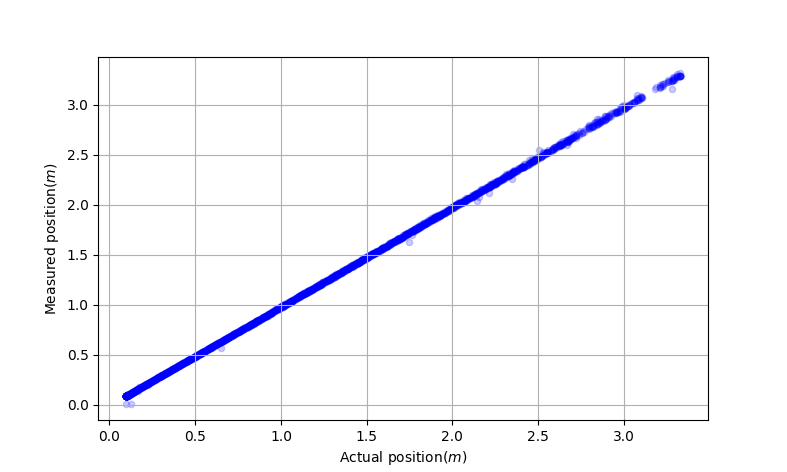

3023 to 2143 data reduction(30%)


In [9]:
""" Decimation of outliers by a reference variance Threeshold
     in a for loop"""
# Data processing 
variance_allow = np.float64(0.1) # choose variance
sonar1_dec= [] #velocity array
distance_dec= [] #timeline array
ref_value = np.float64(0.0) #initialise a ref float
sonar1_dec = np.array(sonar1_dec, dtype = np.float64)#array to arr of floats
distance_dec = np.array(distance_dec, dtype = np.float64)
for i in range(1,len(distance)):
    if(ref_value != 0.0):
        if(abs( sonar1[i]-ref_value)>variance_allow):
            ref_value=ref_value
        else: ref_value= 0.0   
        
    elif(abs(sonar1[i]-sonar1[i-1])<=variance_allow and ref_value == 0.0):
        ref_value = 0.0
        sonar1_dec=np.append(sonar1_dec, sonar1[i])#store in velocity array
        distance_dec=np.append(distance_dec, distance[i])#store in velocity array
    else: ref_value= sonar1[i-1]
        
%matplotlib notebook 
plt.figure(2)
plt.scatter(distance_dec,sonar1_dec, s=20 ,color='blue',label = 'sonar 1',alpha=0.2)
plt.xlabel('Actual position($m$)')#label graph
plt.ylabel('Measured position($m$)')
plt.grid(True)
show()
#attempted decimation inefective, relevant data loss
print(str(len(sonar1))+' to '+str(len(sonar1_dec))+' data reduction(30%)')
sonar1_dec_loop=sonar1_dec
distance_dec_loop=distance_dec
#clear arrays
sonar1_dec= [] #velocity array
distance_dec= [] #timeline array
sonar1_dec = np.array(sonar1_dec, dtype = np.float64)#array to arr of floats
distance_dec = np.array(distance_dec, dtype = np.float64)

<IPython.core.display.Javascript object>


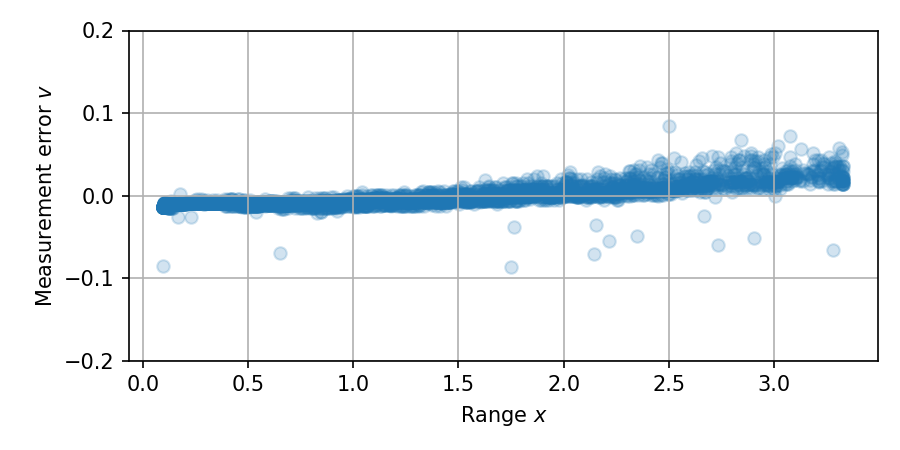

In [10]:
""" Decimation of outliers by a using a reference 
    variance Threeshold in the error function"""

x = distance
m =resrlm2.params
c = resrlm2.bse
h_sonar1= [float(resfit*m + c) for resfit in distance]
v = sonar1 - h_sonar1 #error function v()
# decimation of outliers by v()
error_s1 = 0.09 # maximum error allowed for outliers
h_dec_index=np.array([])
for i in range(0,len(v)):
    if(abs(v[i])<= error_s1):
        sonar1_dec=np.append(sonar1_dec, sonar1[i])#store in velocity array
        distance_dec=np.append(distance_dec, distance[i])#store in velocity array
    else:
        h_dec_index=np.append(h_dec_index,int(i))
h_dec_index = h_dec_index.astype(int) #convert to array of int       
h_sonar1_dec = np.delete(h_sonar1, h_dec_index, axis=None)
v_sonar1_dec = sonar1_dec - h_sonar1_dec
'''Undecimated data error Plot'''
# plt.figure()
# plt.scatter(x,v,alpha = 0.2)
# plt.grid()
# plt.xlabel('Range $x$')
# plt.ylabel('Measurement error $v$')
# show()
'''Decimated data error Plot'''
fig3 = plt.figure(figsize=(6, 3), dpi=150)
plt.scatter(distance_dec,v_sonar1_dec,alpha = 0.2)
plt.grid()
plt.ylim(bottom=-0.2, top=0.2)
plt.xlabel('Range $x$')
plt.ylabel('Measurement error $v$')
fig3.tight_layout()
show()


<IPython.core.display.Javascript object>


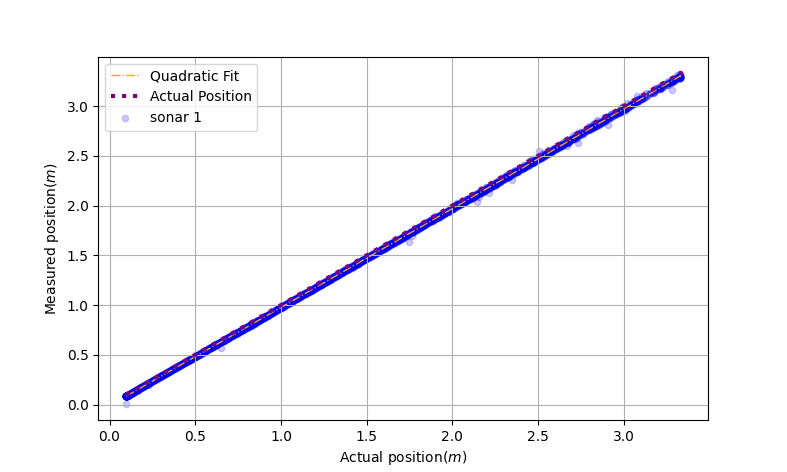

Mean error of the sonar 1 model is
-9.057012168357753e-16


In [11]:
# Second order polynomial fit
p2_sonar1_dec=polyfit(distance_dec,sonar1_dec,2)
c_sonar1, b_sonar1, a_sonar1 = p2_sonar1_dec
h_sonar1_model_dec= [float((((sonar1_model)**2)*c_sonar1)+(sonar1_model*b_sonar1) + a_sonar1) for sonar1_model in distance_dec]

# data plot
plt.figure(4)

plt.rcParams["figure.figsize"] = (20*cm,12*cm) #fig size in cm
plt.scatter(distance_dec,sonar1_dec, s=20 ,color='blue',label = 'sonar 1',alpha=0.2)
plt.plot(distance_dec, (polyval(p2_sonar1_dec,distance_dec)),'-.',linewidth=1, \
         color='orange', label='Quadratic Fit')
plt.plot(distance_dec, distance_dec,':',linewidth=3, \
         color='purple', label='Actual Position')

plt.xlabel('Actual position($m$)')#label graph
plt.ylabel('Measured position($m$)')
plt.grid(True)
plt.legend()
show()
'''mean error of model'''
print('Mean error of the sonar 1 model is')
print((sum(sonar1_dec-h_sonar1_model_dec)/len(sonar1_dec)))


2490
2474


<IPython.core.display.Javascript object>


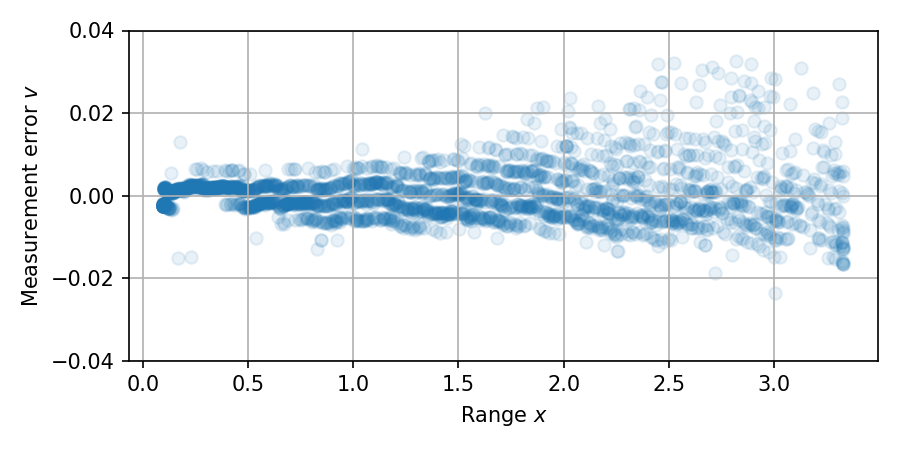

In [5]:

"""Further Decimation of outliers"""
v_sonar1=sonar1_dec-h_sonar1_model_dec
print(len(v_sonar1))
#clear arrays again
sonar1_dec_a= [] #velocity array
distance_dec_a= [] #timeline array
sonar1_dec_a = np.array(sonar1_dec_a, dtype = np.float64)#array to arr of floats
distance_dec_a = np.array(distance_dec_a, dtype = np.float64)

error_s1 = 0.035 # maximum error allowed for outliers

h_dec_index=np.array([])
for i in range(0,len(v_sonar1)):
    if(abs(v_sonar1[i])<= error_s1):
        sonar1_dec_a=np.append(sonar1_dec_a, sonar1_dec[i])#store in velocity array
        distance_dec_a=np.append(distance_dec_a, distance_dec[i])#store in velocity array
    else:
        h_dec_index=np.append(h_dec_index,int(i))
        
h_dec_index = h_dec_index.astype(int) #convert to array of int 

h_sonar1_dec_a = np.delete(h_sonar1_model_dec, h_dec_index, axis=None)

print(len(h_sonar1_dec_a))
v_sonar1_dec_a = sonar1_dec_a - h_sonar1_dec_a

'''Decimated data error Plot with the 2nd deg poly fit'''
fig5 = plt.figure(figsize=(6, 3), dpi=150)
plt.scatter(distance_dec_a,v_sonar1_dec_a,alpha = 0.1)
plt.grid()
plt.ylim(bottom=-0.04, top=0.04)
plt.xlabel('Range $x$')
plt.ylabel('Measurement error $v$')
fig5.tight_layout()
show()

<IPython.core.display.Javascript object>


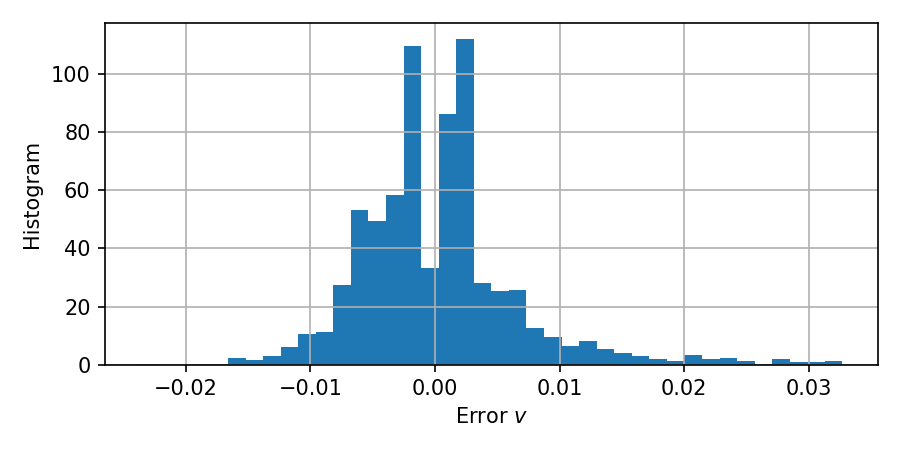

In [6]:
"""Histogram"""
fig6 = plt.figure(figsize=(6, 3), dpi=150)
plt.hist(v_sonar1_dec_a, bins=40, density=True)
plt.grid()
plt.xlabel('Error $v$')
plt.ylabel('Histogram')

fig6.tight_layout()
show()


<IPython.core.display.Javascript object>


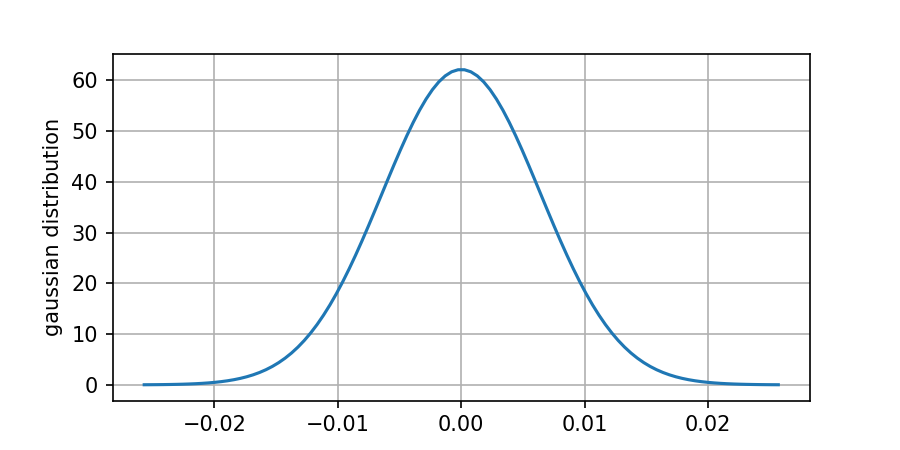

4.124224345511891e-05


In [7]:
"""Gaussian distribution"""
import scipy.stats as stats
import math
from sklearn import metrics
# Standard Deviacion  and 
std_err_sonar1 = np.std(v_sonar1_dec_a)# Standard Deviacion 
var_err_sonar1 = std_err_sonar1**2 #variance
mean_err_sonar=0 # mean error

x = np.arange(-1,1,.01)

x = np.linspace(mean_err_sonar - 4*std_err_sonar1, mean_err_sonar + 4*std_err_sonar1, 100)

fig7 = plt.figure(figsize=(6, 3), dpi=150)
plt.plot(x, stats.norm.pdf(x, mean_err_sonar, std_err_sonar1))
plt.ylabel('gaussian distribution')
plt.grid()
plt.show() 

print(var_err_sonar1)
